In [1]:
%matplotlib inline

import numpy as np
import time
import tensorflow.keras
import pandas as pd
import math
import matplotlib.pyplot as plt

from random import randint

from IPython.display import display

from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Activation, Dropout, Conv2D, Conv2DTranspose
from keras.engine import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import metrics
from tensorflow.keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from tensorflow.keras.datasets import mnist
from tqdm import tnrange, tqdm_notebook

Using TensorFlow backend.


In [2]:
img_rows, img_cols, img_chns = 28, 28, 1
original_img_size = (img_rows, img_cols, img_chns)
batch_size = 500
epochs = 1000
hidden_units = 8000
hidden_layers = 2
learning_rate = 0.0005
dropout = 0.1

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], img_rows * img_cols) / 255.
X_test = X_test.reshape(X_test.shape[0], img_rows * img_cols) / 255.

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


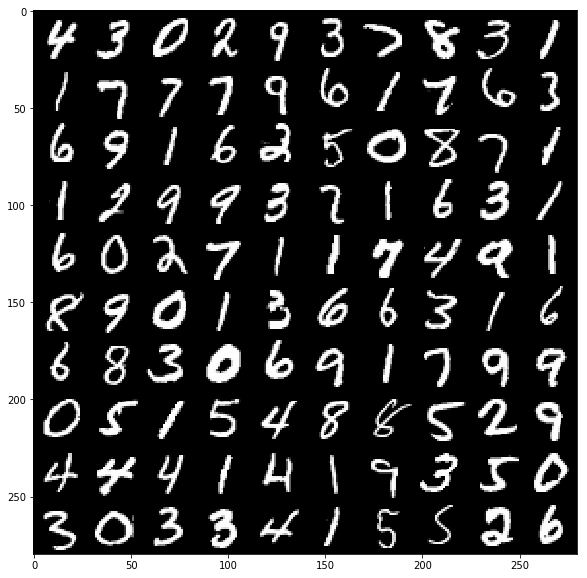

In [4]:
def display_digits(X, digit_size=28, n=10):
    figure = np.zeros((digit_size*n, digit_size*n))
    
    for i in range(n):
        for j in range(n):
            index = np.random.randint(0, X.shape[0])
            digit = X[index].reshape(digit_size, digit_size)
            
            x = i * digit_size
            y = j * digit_size
            figure[x:x+digit_size, y:y+digit_size] = digit
            
    plt.figure(figsize=(n,n))
    plt.imshow(figure, cmap="Greys_r")
    plt.show()
    
display_digits(X_train)

In [5]:
# from tensorflow.keras.layers import initializers
# from tensorflow.keras.layers import activations
# from tensorflow.keras.layers import regularizers
# from tensorflow.keras.layers import constraints
# from keras.engine import InputSpec

In [6]:
class MaskingDense(Layer):
    
    def __init__(self, units, out_units, 
                 hidden_layers=1, 
                 dropout_rate=0.0,
                 random_input_order=False, 
                 activation='relu', 
                 out_activation='sigmoid',
                 kernel_initializer='glorot_uniform', 
                 bias_initializer='zeros', 
                 kernel_regularizer=None,
                 bias_regularizer=None, 
                 activity_regularizer=None, 
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(MaskingDense, self).__init__(**kwargs)
        
        self.input_sel = None
        self.random_input_order = random_input_order
        self.rate = min(1., max(0., dropout_rate))
        self.kernel_sels = []
        self.units = units
        self.out_units = out_units
        self.hidden_layers = hidden_layers
        self.activation = activations.get(activation)
        self.out_activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        
    def dropout_wrapper(self, inputs, training):
        if 0. < self.rate < 1.:
            return K.dropout(inputs, self.rate, noise_shape=None, seed=None)
        return K.in_train_phase(dropped_inputs, inputs,
                                    training=training)
        
    def build_layer_weights(self, input_dim, units, use_bias=True):
        kernel = self.add_weight(shape=(input.sim, units), 
                                 initializer=self.kernel_initializer,
                                 name='kernel', 
                                 regularizer=self.kernel_regularizer, 
                                 constrain=self.kernel_constraint)
        if use_bias:
            bias = self.add_weight(shape=(units,),
                                   initializer=self.bias_initializer,
                                   name='bias',
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        else:
            bias = None
            
        return kernel, bias
    
    def build(self, input_shape):
        assert len(input_shape) >= 2
           
        self.kernels, self.biases = [], []
        self.kernel_masks, self.kernel_sels = [], []
        shape = (input_shape[-1], self.units)
       
        self.input_sel = np.arange(input_shape[-1])
        if self.random_input_order:
            np.random.shuffle(self.input_sel)
        prev_sel = self.input_sel
        for x in range(self.hidden_layers):
            # Hidden layer
            kernel, bias = self.build_layer_weights(*shape)
            self.kernels.append(kernel)
            self.biases.append(bias)
            
            # Hidden layer mask
            kernel_mask, kernel_sel = self.build_mask(shape, prev_sel, is_output=False)
            self.kernel_masks.append(kernel_mask)
            self.kernel_sels.append(kernel_sel)
        
            prev_sel = kernel_sel
            shape = (self.units, self.units)
            
        # Direct connection between input/output
        direct_shape = (input_shape[-1], self.out_units)
        self.direct_kernel, _ = self.build_layer_weights(*direct_shape, use_bias=False)
        self.direct_kernel_mask, self.direct_sel = self.build_mask(direct_shape, self.input_sel, is_output=True)
        
        # Output layer
        out_shape = (self.units, self.out_units)
        self.out_kernel, self.out_bias = self.build_layer_weights(*out_shape)
        self.out_kernel_mask, self.out_sel = self.build_mask(out_shape, prev_sel, is_output=True)
        
        self.built = True
        
    def call(self, inputs, training=None):
        # Hidden layer + mask
        output = inputs
        for i in range(self.hidden_layers):
            weight = self.kernels[i] * self.kernel_masks[i]
            output = K.dot(output, weight)
            output = K.bias_add(output, self.biases[i])
            output = self.activation(output)
            output = self.dropout_wrapper(output, training)
       
        # Direct connection
        direct = K.dot(inputs, self.direct_kernel * self.direct_kernel_mask)
        direct = self.dropout_wrapper(direct, training)
        
        # out_act(bias + (V dot M_v)h(x) + (A dot M_v)x) 
        output = K.dot(output, self.out_kernel * self.out_kernel_mask)
        output = output + direct
        output = K.bias_add(output, self.out_bias)
        output = self.out_activation(output)
        
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.out_units)

In [7]:
def logx_loss(x, x_decoded_mean):
    x = K.flatten(x)
    x_decoded_mean = K.faltten(x_decoded_mean)
    xent_loss = img_roes * img_cols * metrics.binary_crossentropy(x, x_encoded_mean)
    
    return xent_loss

In [8]:
K.set_learning_phase(1)
        
main_input = Input(shape=(img_rows * img_cols,), name='main_input')
mask_1 = MaskingDense(hidden_units, img_rows * img_cols, 
                      hidden_layers=hidden_layers,
                      dropout_rate=dropout,
                      random_input_order=False)(main_input)

model = Model(inputs=main_input, outputs=mask_1)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss=logx_loss)
model.summary()

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [13]:
class base:
    def __init__(self, name):
        self.x = name
        
class A(base):
    def __init__(self):
        print("test")
        super().__init__("ethan")
        print(self.x)

        
c1 = A()

test
ethan


In [19]:
import torch
import torch.nn as nn

In [70]:
np.random.seed(200)
t1 = nn.Linear(2,2, bias=False)
inputs = torch.tensor([[2., 1.], [3., 1.]])
# t1.weight = torch.tensor([[1, 1], [1, 1]])
print(t1.weight)
print(inputs)
a = t1(inputs)
b = t1.forward(inputs)
print(a)
print(b)

Parameter containing:
tensor([[0.2868, 0.6156],
        [0.2325, 0.6205]], requires_grad=True)
tensor([[2., 1.],
        [3., 1.]])
tensor([[1.1892, 1.0855],
        [1.4760, 1.3179]], grad_fn=<MmBackward>)
tensor([[1.1892, 1.0855],
        [1.4760, 1.3179]], grad_fn=<MmBackward>)
